<h1>Gravitational Wave-Induced Freeze-In of Fermionic Dark Matter in the Early Universe</h1>

Azadeh Maleknejad (King's College London) and Joachim Kopp (CERN and JGU Mainz)<br>
arXiv:24XX.YYYYY<br>
jkopp@cern.ch

## Initialization

In [1794]:
%load_ext autoreload
%autoreload 2
%autosave 0
%precision %g

import os, glob, stopit
import re
import copy
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import labellines as ll
import numpy as np
import numpy.random as rnd
import fractions
import scipy.integrate as integ
import scipy.interpolate as interp
import scipy.optimize as opt
import scipy.special as sf
import scipy.stats as stats
import pandas as pd
import orbital
import h5py

# Launch Wolfram language interface
# from wolframclient.evaluation import WolframLanguageSession
# from wolframclient.language import wl, wlexpr
# wl_session = WolframLanguageSession()

# Directories
base_dir = os.path.expanduser("~/Dropbox/nr-from-gw/")
os.chdir(base_dir)

# set up matplotlib
%matplotlib inline
matplotlib.rcParams['text.usetex']    = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,siunitx} \usepackage[T1]{fontenc}'
matplotlib.rcParams['font.family']    = 'serif'
matplotlib.rcParams['font.size']      = '16'
matplotlib.rcParams['figure.figsize'] = 6.4, 4.8

# Unit conversion and physical constants
class my_units:
    # Energy and mass
    eV     = 1.
    keV    = 1.e3
    MeV    = 1.e6
    GeV    = 1.e9
    TeV    = 1.e12
    PeV    = 1.e15
    kg     = 5.62e35*eV
    grams  = 0.001*kg
    Kelvin = 8.617333262e-5       # PDG 2022
    Joule  = 1/1.602176634e-19*eV # PDG 2022 [exact]
    erg    = 1e-7*Joule
    
    # Length and time
    m     = 5.076e6
    meter = m
    km    = 1000*m
    cm    = 0.01*m
    nm    = 1.e-9*m
    fm    = 1.e-15*m
    AU    = 1.4960e11*m
    pc    = 30.857e15*m
    kpc   = 1.e3*pc
    Mpc   = 1.e6*pc
    Gpc   = 1.e9*pc
    ly    = 9460730472580800*m  # light year
    sec   = 1.523e15
    hours = 3600*sec
    days  = 24*hours
    yrs   = 365*days
    Hz    = 1./sec
    kHz   = 1.e3*Hz
    MHz   = 1.e6*Hz
    GHz   = 1.e9*Hz
    
    barn  = 1.e-24*cm**2
    pb    = 1.e-36*cm**2
    fb    = 1.e-39*cm**2
    
    # Various astrophysical constants
    GN    = 6.708e-39/1e18  # eV^-2, Newton's constant
    MPl   = 1.22093e19*GeV   # Planck mass, PDG 2013
    Msun  = 1.989e30*kg
    Rsun  = 6.9551e8*meter
    
    # cosmology
    h        = 0.674                         # according to Planck 2018
    H0       = h * 100. * km / sec/ Mpc      # Hubble parameter
    rho_c0   = 3. * H0**2/(8. * np.pi * GN)  # critical density today, Kolb Turner eq. (3.14)
    Omega_dm = 0.12 / h**2                   # dark matter density, Planck 2018
    T0       = 2.726 * Kelvin                # photon temperature today
    
    # particle physics
    alpha_em = (1./137.035999139)            # electromagnetic fine structure constant (PDG 2018)
    GF       = 1.166378e-5 / GeV**2          # Fermi constant (PDG 2022)
    s2thW    = 1.03232 * 0.23121             # sin^2 \theta_W(M_Z) from PDG 2022; \kappa from https://arxiv.org/abs/1608.02671
    m_e      = 0.5109989461 * MeV            # electron mass (PDG 2018)
    m_mu     = 105.6583745 * MeV             # muon mass (PDG 2018)
    m_tau    = 1776.86 * MeV                 # tau mass (PDG 2018)
    m_p      = 938.2720813 * MeV             # proton mass (PDG 2018)
    m_n      = 939.565413 * MeV              # neutron mass (PDG 2018)
    m_u      = 931.4940954 * MeV             # atomic mass unit (PDG 2018)
    m_b      = 4.18 * GeV                    # bottom quark mass (PDG 2023)
    m_t      = 172.69 * GeV                  # top quark mass (PDG 2023)
    m_pi0    = 134.9768 * MeV                # neutral pion mass (PDG 2020)
    tau_mu   = 2.1969811e-6 * sec            # muon lifetime (PDG 2018)
    gA       = 1.26                          # axial coupling constant of the proton
    
    # PDG codes
    pdg_nu_e      = 12
    pdg_nu_mu     = 14
    pdg_nu_tau    = 16
    pdg_e         = 11
    pdg_mu        = 13
    pdg_tau       = 15
    pdg_gamma     = 22
    pdg_pip       = 211
    pdg_pi0       = 111
    pdg_KL        = 130
    pdg_Kp        = 321
    pdg_Dp        = 411
    pdg_D0        = 421
    pdg_Dp2s_2460 = 415
    pdg_D02s_2460 = 425
    pdg_Dsp       = 431
    pdg_Dsps      = 433
    pdg_Ds2s_2573 = 435
    
u = my_units()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosave disabled


## Plot of the DM Energy Density – Old and Incorrect Calculation

In [1795]:
def g_star_S(T):
    """effective number of degrees of freedom in the Universe
       (for the purposes of calculating the entropy density)
       
       Note: we use g_{*S} here (effective number of relativistic
       degrees of freedom in the entropy density). This is correct
       for computing dilution of number densities for instance,
       which depend on conservation of entropy.

       Parameters:
           T: photon temperature"""
    
    if T > u.m_t:
        return 106.75
    elif T > 30*u.GeV:
        return 96.25
    elif T > u.m_b/6:
        return 86.25
    elif T > u.m_tau/6:
        return 75.75
    elif T > 150*u.MeV:
        return 61.75
    elif T > 100*u.MeV:
        return 17.25
    elif T > 1*u.MeV:
        return 10.75
    else:
        return 3.94;

def Hubble(T):
    """the Hubble parameter as function of temperature during radiation domination"""
    
    g = g_star_S(T)  # strictly speaking, this should be g_star, not g_star_S. But at the temperatures
                     # we are interested in, they are the same
    return 1.66 * np.sqrt(g) * T**2 * np.sqrt(u.GN)

def A_incoh(n, q_max, q_peak, m):
    if n < 4:
        return 1/(4-n) * (q_max/q_peak)**(4-n)
    elif n == 4:
        return np.log(q_max/q_peak)
    elif n > 4:
        return (n + m) / ((4 + m) * (n - 4))

def rho_R(T, T_star, n=4, m=3, q_peak=1*u.Hz, Omega_peak=1e-6, beta_over_H=100., q_max=None, coherent=True):
    """The (physical, not conformal) fermion energy density at temperature T
       (after production has stopped)
    
       Parameters:
           T:           the temperature at which rho_R should be evaluated
           T_star:      the temperature at which production stops
           n:           the (negative of the) spectral index at frequencies above the peak
           m:           the spectral index at frequencies below the peak
           q_peak:      the (comoving) peak frequency of the GW spectrum
                        or, equivalently, the peak frequency today
           Omega_peak:  relative gravitational wave energy density at the peak
           beta_over_H: the beta parameter that specifies the speed of the phase transition
           q_max:       maximum graviton momentum (default: None = set to T_star)
           coherent:    whether or not to assume a coherent GW source"""
    
    a           = u.T0 * g_star_S(u.T0)**(1/3) / (T * g_star_S(T)**(1/3))
    a_star      = u.T0 * g_star_S(u.T0)**(1/3) / (T_star * g_star_S(T_star)**(1/3))
    z_star      = 1/a_star - 1
    H_star      = a_star * Hubble(T_star) # this is the *conformal* Hubble parameter
    if q_max is None:
        q_max   = max(q_peak, a_star * T_star) # factor a_star to transform to momenta today
    beta        = beta_over_H * H_star
    Delta_eta   = 1. / beta
    if coherent:
        alpha   = 1.
        if n < 4:    C = 1/(4-n)*(q_max/q_peak)**(4-n)
        elif n == 4: C = np.log(q_max/q_peak) + 1.5 * (beta/q_peak**2)
        else:        C = (n+m) / (4+m) * (1/(n-4) + 3/(n-2)*(beta/q_peak)**2)
    else:
        alpha   = 2*np.log(2) / np.pi * beta*Delta_eta
        if n < 4:    C = 1/(4-n)*(q_max/q_peak)**(4-n)
        elif n == 4: C = np.log(q_max/q_peak)
        else:        C = (n+m) / ((4+m)*(n-4))
        
    return 2 * np.pi * alpha * C * q_peak**4 / a**4 * u.H0**2 / H_star**2 * z_star**2 * Omega_peak

def Omega_DM(M, T_star, n=4., m=3., q_peak=1*u.Hz, Omega_peak=1e-6, beta_over_H=100., q_max=None, coherent=True):
    """The dimensionless fermion energy density today
    
       Parameters:
           M:          the fermion mass
           T_star:     the temperature at which production stops
           n:          the (negative of the) spectral index at frequencies above the peak
           m:          the spectral index at frequencies below the peak
           q_peak_over_Hstar: ratio between the peak frequency of the GW spectrum and the
                       Hubble parameter at the time of fermion production
           Omega_peak: relative gravitational wave energy density at the peak.
           beta_over_H: the beta parameter that specifies the speed of the phase transition
           q_max:       maximum graviton momentum (default: None = set to T_star)
           coherent:    whether or not to assume a coherent GW source"""
        
    s = u.T0**3*g_star_S(u.T0) / (M**3*g_star_S(M))  # dilution factor for the period from T=M to today
    return s * rho_R(T=M, T_star=T_star, n=n, m=m, q_peak=q_peak, q_max=q_max, Omega_peak=Omega_peak,
                     beta_over_H=beta_over_H, coherent=coherent) / u.rho_c0

def Omega_DM_2(M, T_star, n=4., m=3., q_peak=1*u.Hz, Omega_peak=1e-6, beta_over_H=100., q_max=None, coherent=True):
    """The dimensionless fermion energy density today - alternative implementation
    
       Parameters:
           M:          the fermion mass
           T_star:     the temperature at which production stops
           n:          the (negative of the) spectral index at frequencies above the peak
           m:          the spectral index at frequencies below the peak
           q_peak_over_Hstar: ratio between the peak frequency of the GW spectrum and the
                       Hubble parameter at the time of fermion production
           Omega_peak: relative gravitational wave energy density at the peak.
           beta_over_H: the beta parameter that specifies the speed of the phase transition
           q_max:       maximum graviton momentum (default: None = set to T_star)
           coherent:    whether or not to assume a coherent GW source"""
    
    a_star      = u.T0 * g_star_S(u.T0)**(1/3) / (T_star * g_star_S(T_star)**(1/3))
    z_star      = 1/a_star - 1
    H_star      = a_star * Hubble(T_star) # this is the *conformal* Hubble parameter
    if q_max is None:
        q_max   = max(q_peak, a_star * T_star) # factor a_star to transform to momenta today
    beta        = beta_over_H * H_star
    Delta_eta   = 1. / beta
    if coherent:
        alpha   = 1.
        if n < 4:    C = 1/(4-n)*(q_max/q_peak)**(4-n)
        elif n == 4: C = np.log(q_max/q_peak) + 1.5 * (beta/q_peak)**2
        else:        C = (n+m) / (4+m) * (1/(n-4) + 3/(n-2)*(beta/q_peak)**2)
    else:
        alpha   = 2*np.log(2) / np.pi * beta*Delta_eta
        if n < 4:    C = 1/(4-n)*(q_max/q_peak)**(4-n)
        elif n == 4: C = np.log(q_max/q_peak)
        else:        C = (n+m) / ((4+m)*(n-4))

    return 0.26 * alpha * C * (M/T_star) * (q_peak/H_star/100)**4 * (g_star_S(T_star)/106.75)**(2/3) \
            * (T_star / (3e11*u.GeV))**5 * Omega_peak/1e-6

def Omega_CGPP(M, T_reh):
    """Compute the energy density today from conventional cosmological heavy scalar production.
       See eq. 77 of https://arxiv.org/abs/2312.09042.
    
       Parameters:
           M:     the fermion mass
           T_reh: the reheating temperature"""
    
    return 0.7 * (M / (1e11*u.GeV))**2 * (T_reh/(1e9*u.GeV))

def Omega_gw(f, source, T, alpha=0.1, beta_over_H=100., vw=0.99, alpha_run=np.inf):
    """compute the gravitational wave energy density d\Omega_gw/d\ln(f)
       according to eq. 3.27 in https://arxiv.org/abs/2204.13735
       
       Parameters:
           f:           GW frequency
           source:      'phi', 'sw', or 'turb'
           T:           temperature of the PT
           alpha:       the strength of the PT
           beta_over_H: the speed of the PT (the beta/H parameter)
           vw:          bubble wall velocity
           alpha_run:  the limiting alpha beyond which runaway bubbles are realized"""
    
    H    = Hubble(T)
    beta = beta_over_H * H
    if source == 'phi':
        Omega_0     = 1.67e-5
        f_p         = 0.62 * beta / (1.8 - 0.1*vw + vw**2)
        fp0         = u.T0 / T * (g_star_S(u.T0) / g_star_S(T))**(1/3) * f_p
        kappa       = np.where(alpha>alpha_run, 1 - alpha_run / alpha, 0.)
        a           = 2
        b           = 2
        V           = 0.11 * vw**3 / (0.42 + vw**2)
        S           = 3.8 * (f/fp0)**2.8 / (1 + 2.8*(f/fp0)**3.8)
    elif source == 'sw': 
        Omega_0     = 2.65e-6
        f_p         = 2 * beta / (np.sqrt(3) * vw)
        fp0         = u.T0 / T * (g_star_S(u.T0) / g_star_S(T))**(1/3) * f_p
        kappa       = np.where(alpha>alpha_run, alpha_run / (0.73 + 0.083*np.sqrt(alpha_run) + alpha_run),
                                                alpha / (0.73 + 0.083*np.sqrt(alpha) + alpha))
        a           = 2
        b           = 1
        V           = vw
        S           = (f/fp0)**3 * (7/ (4 + 3*(f/fp0)**2))**(7/2)
    elif source == 'turb':
        Omega_0     = 3.35e-4
        f_p         = 3.5 * beta / (2 * vw)
        fp0         = u.T0 / T * (g_star_S(u.T0) / g_star_S(T))**(1/3) * f_p
        kappa       = 0.1 * np.where(alpha>alpha_run, alpha_run / (0.73 + 0.083*np.sqrt(alpha_run) + alpha_run),
                                                      alpha / (0.73 + 0.083*np.sqrt(alpha) + alpha))
        a           = 1.5
        b           = 1
        V           = vw
        S           = (f/fp0)**3 / ( (1 + f/fp0)**(11/3) * (1 + 8*np.pi*f/fp0 * f_p/H) )
    else:
        raise ValueError(f"invalid GW source: {source}. Valid values are 'phi', 'sw', or 'turb'.")
    
    return Omega_0 * (100/106.75)**(1/3) * (kappa * alpha / (1 + alpha))**a * (H/beta)**b * V * S    

In [284]:
T_star=1e9*u.GeV
Omega_DM_2(M=1e4*u.GeV, T_star=T_star, n=4, Omega_peak=1e-10,
                                             q_peak=100 * u.T0*g_star_S(u.T0)**(1/3)/(T_star*g_star_S(T_star)**(1/3)) * Hubble(T_star),
                                             beta_over_H=100, coherent=True)

1.8487e-21

/var/folders/sd/hm2ph8vn5cl61qsssm31k1940000gn/T/ipykernel_94713/2415144924.py:126: RuntimeWarning: invalid value encountered in scalar divide
  kappa       = np.where(alpha>alpha_run, alpha_run / (0.73 + 0.083*np.sqrt(alpha_run) + alpha_run),
/var/folders/sd/hm2ph8vn5cl61qsssm31k1940000gn/T/ipykernel_94713/2415144924.py:136: RuntimeWarning: invalid value encountered in scalar divide
  kappa       = 0.1 * np.where(alpha>alpha_run, alpha_run / (0.73 + 0.083*np.sqrt(alpha_run) + alpha_run),


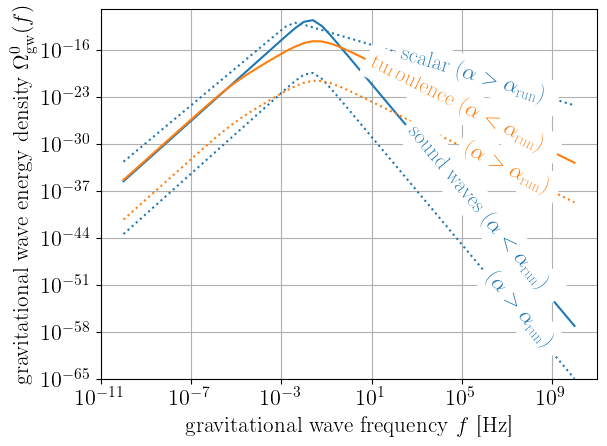

In [3]:
# sample GW spectra
f_table = np.logspace(-10,10,51)*u.Hz
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(f_table/u.Hz, [ Omega_gw(f, source='sw',   T=1*u.TeV, alpha_run=np.inf) for f in f_table ],
         c=default_colors[0], label=r'sound waves ($\alpha < \alpha_\text{run}$)')
plt.plot(f_table/u.Hz, [ Omega_gw(f, source='turb', T=1*u.TeV, alpha_run=np.inf) for f in f_table ],
         c=default_colors[1], label=r'turbulence ($\alpha < \alpha_\text{run}$)')

plt.plot(f_table/u.Hz, [ Omega_gw(f, source='phi',  T=1*u.TeV, alpha_run=0.00001) for f in f_table ],
         c=default_colors[0], ls=':', label=r'scalar ($\alpha > \alpha_\text{run}$)')
plt.plot(f_table/u.Hz, [ Omega_gw(f, source='sw',   T=1*u.TeV, alpha_run=0.00001) for f in f_table ],
         c=default_colors[0], ls=':', label=r'($\alpha > \alpha_\text{run}$)')
plt.plot(f_table/u.Hz, [ Omega_gw(f, source='turb', T=1*u.TeV, alpha_run=0.00001) for f in f_table ],
         c=default_colors[1], ls=':', label=r'($\alpha > \alpha_\text{run}$)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'gravitational wave frequency $f$ [Hz]')
plt.ylabel(r'gravitational wave energy density $\Omega_\text{gw}^0(f)$')
ll.labelLines(plt.gca().get_lines(), xvals=(1e9,1e9,1e9,1e9,1e9), ha='right', align=True, backgroundcolor='white')
plt.ylim(1e-65,1e-10)
plt.grid()
plt.show()

/var/folders/sd/hm2ph8vn5cl61qsssm31k1940000gn/T/ipykernel_94713/1657648773.py:57: RuntimeWarning: divide by zero encountered in log10
  cp = ax1.contour(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table[n,alpha,coh]),
/var/folders/sd/hm2ph8vn5cl61qsssm31k1940000gn/T/ipykernel_94713/1657648773.py:59: RuntimeWarning: divide by zero encountered in log10
  ax1.contourf(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table[n,alpha,coh]),


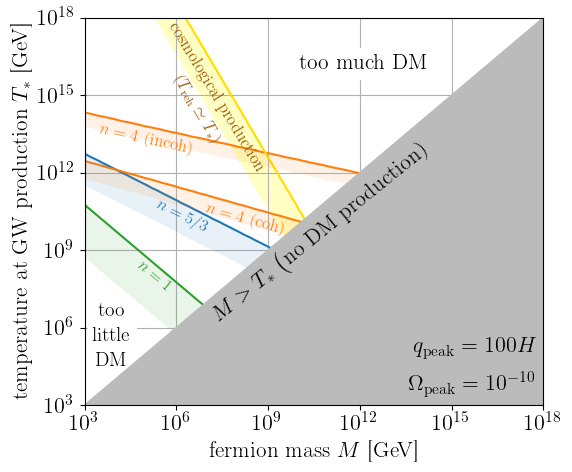

In [303]:
# parameter space plots
# ---------------------

# calculate Omega tables for realistic PT spectra
# Omega_R_table = {}
# peak_table    = {}
# n_table       = {'turb': 5/3, 'sw': 4, 'phi': 1} # see https://arxiv.org/abs/2204.09661 and references therein
# M_table       = np.logspace(3, 18, 76) * u.GeV
# T_star_table  = np.logspace(3, 18, 76) * u.GeV
# for s in ['phi', 'sw', 'turb']:
#     peak_table[s,'norun'] = [ opt.minimize(lambda logf: -Omega_gw(10**logf, source=s, T=T, alpha_run=np.inf),
#                                            x0=np.log10(100*Hubble(T)), method='Powell')
#                                   for T in T_star_table ]
#     peak_table[s,'run'] = [ opt.minimize(lambda logf: -Omega_gw(10**logf, source=s, T=T, alpha_run=0.00001),
#                                            x0=np.log10(100*Hubble(T)), method='Powell')
#                                   for T in T_star_table ]
#     for r in ['run','norun']:
#         Omega_R_table[s,r] = np.array([[Omega_DM(M, T_star, n=n_table[s], q_peak=2*np.pi*10**p.x[0], Omega_peak=-p.fun)
#                                       for M in M_table] for p, T_star in zip(peak_table[s,r], T_star_table)]) / u.rho_c0

# calculate lower-level Omega tables for more generic GW sources
Omega_R_table = {}
M_table       = np.logspace(3, 18, 76) * u.GeV
T_star_table  = np.logspace(3, 18, 76) * u.GeV
alpha_table   = [100,     100,  100,   100]
n_table       = [5/3,       4,    4,     1]
coh_table     = [False, False, True, False]
#alpha_table   = [100, 100, 100, 1000, 1000, 1000]
#n_table       = [5/3,   4,   1,  5/3,    4,    1]
for n, alpha, coh in zip(n_table, alpha_table, coh_table):
    Omega_R_table[n, alpha, coh] = np.array([[Omega_DM(M=M, T_star=T_star, n=n, Omega_peak=1e-10,
                                             q_peak=alpha * u.T0*g_star_S(u.T0)**(1/3)/(T_star*g_star_S(T_star)**(1/3)) * Hubble(T_star),
                                             beta_over_H=alpha, coherent=coh)
                              for M in M_table] for T_star in T_star_table])

# This custom formatter removes trailing zeros, e.g. "1.0" becomes "1", and
# then adds a percent sign.
def fmt_log(x):
    s = f"{np.log10(x):.1f}"
    if s.endswith("0"):
        s = f"{np.log10(x):.0f}"
    return s

# plot Omega
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
my_colors      = [ default_colors[0], default_colors[1], default_colors[1], default_colors[2]]
fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(111)
ax1.set_xscale('log')
ax1.set_yscale('log')
#for s in ['phi']:
#    cp = ax1.contour(M_table/u.GeV, T_star_table/u.GeV, Omega_R_table[s,'run'], levels=[0,u.Omega_dm],
#                     colors=['k'])
#    ax1.contour(M_table/u.GeV, T_star_table/u.GeV, Omega_R_table[s,'run'], levels=[0,u.Omega_dm],
#                colors=['k'])
for j, n, alpha, coh in zip(range(len(n_table)), n_table, alpha_table, coh_table):
    cp = ax1.contour(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table[n,alpha,coh]),
                     levels=[np.log10(u.Omega_dm)], colors=[my_colors[j]], linestyles=['-'])
    ax1.contourf(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table[n,alpha,coh]),
                 levels=[np.log10(0.01*u.Omega_dm),np.log10(u.Omega_dm)],
                 colors=[my_colors[j]], alpha=0.1, zorder=2.5)
#    cl = ax1.clabel(cp, inline=False, fontsize=14, fmt=lambda x: r'$q_\text{{peak}} = {:d} \, \mathcal{{H}}_*$'.format(alpha))
    if n == 4 and coh == True:
        loc   = [(3e7,2e7)]
        label = r'$n = {:s}$ (coh)'.format(str(n))
    elif n == 4 and coh == False:
        loc   = [(5e4,5e11)]
        label = r'$n = {:s}$ (incoh)'.format(str(n))
    elif n == 5/3:
        loc   = [(6e3,1e5)]
        label = r'$n = {:s}$'.format(str(fractions.Fraction(n).limit_denominator()))
    else:
        loc   = [(1e5,1e8)]
        label = r'$n = {:s}$'.format(str(n))
    cl = ax1.clabel(cp, inline=False, fontsize=12, manual=loc, fmt=lambda x: label)
#    cl[0].set_rotation(-15)
#    cl[0].set_x(cl[0]._x/1e4)
    cl[0].set_y(cl[0]._y/3)
#    cl = ax1.clabel(cp, cp.levels, inline=True, inline_spacing=0, fmt='%.2f', colors=['k'], use_clabeltext=False)
#    cl[0].set_bbox(dict(boxstyle='square',fc='white', edgecolor='white', lw=None))
#    ax1.clabel(cp, inline=False, fmt=r'$q_\text{{peak}} = {:d} \mathcal{{H}}_*'.format(alpha))
#for s in ['phi', 'sw', 'turb']:
#    cp = ax1.contour(M_table/u.GeV, T_star_table/u.GeV, Omega_R_table[s,'run'],   levels=[0.24], ls=":")
#    cp = ax1.contour(M_table/u.GeV, T_star_table/u.GeV, Omega_R_table[s,'norun'], levels=[0.24])
#ax1.clabel(cp, cp.levels, fmt=fmt_log, inline=False)

# plot Omega from conventional heavy fermion production
Omega_R_table['cgpp'] = np.array([[Omega_CGPP(M, T_star) for M in M_table] for T_star in T_star_table])
cp2 = ax1.contour (M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table['cgpp']), levels=[np.log10(u.Omega_dm)],
             colors=['#ffdd00'], linestyles=['-'])
ax1.contourf(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table['cgpp']), levels=[np.log10(0.01*u.Omega_dm),np.log10(u.Omega_dm)],
             colors=['#ffffaa'], alpha=0.7)
cl2 = ax1.clabel(cp2, inline=False, manual=[(1e5,1e15)], fontsize=12,
                 fmt=lambda x: r'\parbox{10cm}{\centering cosmological production\\[0.5ex]\large ($T_\text{reh} \simeq T_*$)}')
cl2[0].set_y(cl2[0]._y/80)
cl2[0].set_color('#995500')

# annotation and fine-tuning of the plot
ax1.fill_between(M_table/u.GeV, M_table/u.GeV, 1e-20, color='#bbbbbb', zorder=2.5)
ax1.annotate(r'$M > T_*$ {\big (no DM production)}', (1e7,2e6), rotation=39)
ax1.annotate(r'too much DM', (1e10,1e16), backgroundcolor='white')
ax1.annotate(r'\parbox{1.8cm}{\centering\Large too little DM', (1.8e3,8e6), ha='left', va='top',
             bbox=dict(boxstyle='square', pad=0.2, fc='white', edgecolor='white', lw=None), zorder=2)
ax1.annotate(r'$q_\text{peak} = 100 H$', (0.98,0.12), xycoords='axes fraction', ha='right', va='bottom')
ax1.annotate(r'$\Omega_\text{peak} = 10^{-10}$', (0.98,0.02), xycoords='axes fraction', ha='right', va='bottom')

ax1.set_xlabel(r'fermion mass $M$ [GeV]')
ax1.set_ylabel(r'temperature at GW production $T_*$ [GeV]')
ax1.set_xlim(min(M_table/u.GeV), max(M_table/u.GeV))
ax1.set_ylim(min(T_star_table/u.GeV), max(T_star_table/u.GeV))
ax1.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([1e3,1e6,1e9,1e12,1e15,1e18]))
#ax1.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(10**np.arange(3,18)))
ax1.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([1e3,1e6,1e9,1e12,1e15,1e18]))
ax1.grid()

plt.tight_layout()
plt.savefig('OmegaD-Plot.pdf')
plt.show()

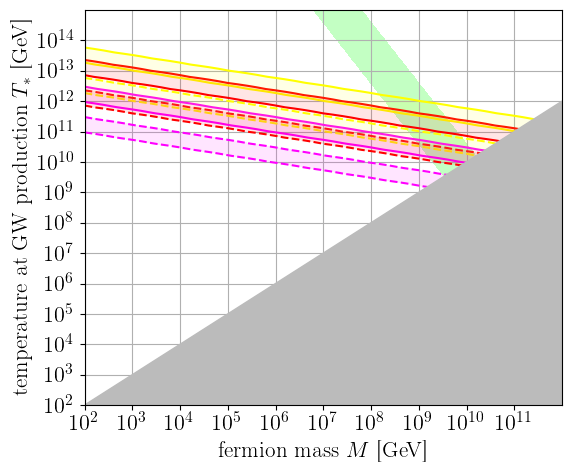

In [278]:
# comparison with Azadeh's plots
# NOTE: small discrepancies arise from Azadeh's use of an approximate numerical prefactor
#       in the M-T_star relation (1e14 instead of 2.22e14)

Omega_R_table = {}
M_table       = np.logspace(2, 12, 51) * u.GeV
T_star_table  = np.logspace(2, 15, 66) * u.GeV
alpha_table   = [100, 100, 100, 1000, 1000, 1000]
n_table       = [  1,   3,   5,    1,    3,    5]
for n, alpha in zip(n_table, alpha_table):
    Omega_R_table[n, alpha] = np.array([[Omega_DM_2(M=M, T_star=T_star, n=n, Omega_peak=1e-6,
                                             q_peak=alpha * u.T0*g_star_S(u.T0)**(1/3)/(T_star*g_star_S(T_star)**(1/3)) * Hubble(T_star),
                                             q_max=100 * alpha * u.T0*g_star_S(u.T0)**(1/3)/(T_star*g_star_S(T_star)**(1/3)) * Hubble(T_star),
                                             beta_over_H=alpha, coherent=True)
                              for M in M_table] for T_star in T_star_table])
    
my_colors = ['magenta','red','yellow','magenta','red','yellow']
my_ls     = ['-',      '-',      '-', '--',     '--', '--'    ]
fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(111)
ax1.set_xscale('log')
ax1.set_yscale('log')
#for s in ['phi']:
#    cp = ax1.contour(M_table/u.GeV, T_star_table/u.GeV, Omega_R_table[s,'run'], levels=[0,u.Omega_dm],
#                     colors=['k'])
#    ax1.contour(M_table/u.GeV, T_star_table/u.GeV, Omega_R_table[s,'run'], levels=[0,u.Omega_dm],
#                colors=['k'])
for j, n, alpha in zip(range(len(n_table)), n_table, alpha_table):
    cp = ax1.contour(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table[n,alpha]), levels=[np.log10(0.01*u.Omega_dm),np.log10(u.Omega_dm)],
                     colors=[my_colors[j]], linestyles=[my_ls[j]])
    ax1.contourf(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table[n,alpha]), levels=[np.log10(0.01*u.Omega_dm),np.log10(u.Omega_dm)],
                 colors=[my_colors[j]], alpha=0.1, zorder=2.5)

# plot Omega from conventional heavy fermion production
Omega_R_table['cgpp'] = np.array([[Omega_CGPP(M, T_star) for M in M_table] for T_star in T_star_table])
ax1.contourf(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table['cgpp']), levels=[np.log10(0.01*u.Omega_dm),np.log10(u.Omega_dm)],
             colors=['#aaffaa'], alpha=0.7)

# annotation and fine-tuning of the plot
ax1.fill_between(M_table/u.GeV, M_table/u.GeV, 1e-20, color='#bbbbbb', zorder=2.5)
ax1.set_xlabel(r'fermion mass $M$ [GeV]')
ax1.set_ylabel(r'temperature at GW production $T_*$ [GeV]')
ax1.set_xlim(min(M_table/u.GeV), max(M_table/u.GeV))
ax1.set_ylim(min(T_star_table/u.GeV), max(T_star_table/u.GeV))
ax1.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(10**np.arange(2,12)))
ax1.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(10**np.arange(2,15)))
ax1.grid()

plt.tight_layout()
plt.show()

## Plot of the DM Energy Density – Current Calculation

In [1798]:
def g_star_S(T):
    """effective number of degrees of freedom in the Universe
       (for the purposes of calculating the entropy density)
       
       Note: we use g_{*S} here (effective number of relativistic
       degrees of freedom in the entropy density). This is correct
       for computing dilution of number densities for instance,
       which depend on conservation of entropy.

       Parameters:
           T: photon temperature"""
    
    if T > u.m_t:
        return 106.75
    elif T > 30*u.GeV:
        return 96.25
    elif T > u.m_b/6:
        return 86.25
    elif T > u.m_tau/6:
        return 75.75
    elif T > 150*u.MeV:
        return 61.75
    elif T > 100*u.MeV:
        return 17.25
    elif T > 1*u.MeV:
        return 10.75
    else:
        return 3.94;

def Hubble(T):
    """the Hubble parameter as function of temperature during radiation domination"""
    
    g = g_star_S(T)  # strictly speaking, this should be g_star, not g_star_S. But at the temperatures
                     # we are interested in, they are the same
    return 1.66 * np.sqrt(g) * T**2 * np.sqrt(u.GN)

def Omega_DM(M, T_star, n=4., m=3., q_peak=1*u.Hz, Omega_peak=1e-6, beta_over_H=100, q_max=None, coherent=True):
    """The dimensionless fermion energy density today - alternative implementation
    
       Parameters:
           M:          the fermion mass
           T_star:     the temperature at which production stops
           n:          the (negative of the) spectral index at frequencies above the peak
           m:          the spectral index at frequencies below the peak
           q_peak:     the peak frequency of the GW spectrum
           Omega_peak: relative gravitational wave energy density at the peak.
           beta_over_H: the beta parameter that specifies the speed of the phase transition
           q_max:       maximum graviton momentum (default: None = set to T_star)
           coherent:    whether or not to assume a coherent GW source"""
    
    a_star      = u.T0 * g_star_S(u.T0)**(1/3) / (T_star * g_star_S(T_star)**(1/3))
    z_star      = 1/a_star - 1
    H_star      = a_star * Hubble(T_star) # this is the *conformal* Hubble parameter
    if q_max is None:
        q_max   = max(q_peak, a_star * T_star) # factor a_star to transform to momenta today
    beta        = beta_over_H * H_star
    Delta_eta   = 1. / beta
    if coherent:
#         C = 1/(m+4) * ( 6.05 * (m+4)**2 * np.log( np.pi*beta/(2*q_peak) )**2
#                       - (5.07*m**2 + 28.5*m + 32.7) * np.log( np.pi*beta/(2*q_peak) )
#                       + 16.1*m**2 + 124*m + 249. )
#         if n != 2:  C += 6.65 * (beta / q_peak)**2 * 1/(n-2) * ( 1 - (q_peak/q_max)**(n-2) )
#         else:       C += 6.05 * (beta / q_peak)**2 * np.log(q_max/q_peak)
        C = 1/(m+4) * ( 0.059 + (0.047/(m+4) - 0.0015) * np.log(beta/q_peak)
                              + 0.023 * np.log(beta/q_peak)**2 )
        if n != 2:  C += 0.023 * (beta / q_peak)**2 * 1/(n-2) * ( 1 - (q_peak/q_max)**(n-2) )
        else:       C += 0.023 * (beta / q_peak)**2 * np.log(q_max/q_peak)
    else:
        C = 107*np.log(2)/(231*np.pi) * Delta_eta * beta
        if n < 4:    C = 1/(4-n)*(q_max/q_peak)**(4-n)
        elif n == 4: C = np.log(q_max/q_peak)
        else:        C = (n+m) / ((4+m)*(n-4))
            
    return 0.39 * C * (M/T_star) * (q_peak/H_star/100)**4 * (g_star_S(T_star)/106.75)**(4/3) \
            * (T_star / (3e11*u.GeV))**5 * Omega_peak/1e-6

def Omega_CGPP(M, T_reh):
    """Compute the energy density today from conventional cosmological heavy fermion production.
       See eq. 77 of https://arxiv.org/abs/2312.09042.
    
       Parameters:
           M:     the fermion mass
           T_reh: the reheating temperature"""
    
    return 0.7 * (M / (1e11*u.GeV))**2 * (T_reh/(1e9*u.GeV))

def Omega_GMA(M, T_reh):
    """Compute the energy density today from graviton-mediated inflaton annihilation
       See eq. 16 of https://arxiv.org/abs/1803.01866.
    
       Parameters:
           M:     the fermion mass
           T_reh: the reheating temperature"""
    
    return 0.1/u.h**2 * 8e-17 * 1.1e-3/1.9e-4 * (M / (1*u.GeV)) * (T_reh/(1e12*u.GeV))**3
                                 # see Table I of 1803.01866 for values of \alpha

def Omega_gw(f, source, T, alpha=0.1, beta_over_H=100., vw=0.99, alpha_run=np.inf):
    """compute the gravitational wave energy density d\Omega_gw/d\ln(f)
       according to eq. 3.27 in https://arxiv.org/abs/2204.13735
       
       Parameters:
           f:           GW frequency
           source:      'phi', 'sw', or 'turb'
           T:           temperature of the PT
           alpha:       the strength of the PT
           beta_over_H: the speed of the PT (the beta/H parameter)
           vw:          bubble wall velocity
           alpha_run:  the limiting alpha beyond which runaway bubbles are realized"""
    
    H    = Hubble(T)
    beta = beta_over_H * H
    if source == 'phi':
        Omega_0     = 1.67e-5
        f_p         = 0.62 * beta / (1.8 - 0.1*vw + vw**2)
        fp0         = u.T0 / T * (g_star_S(u.T0) / g_star_S(T))**(1/3) * f_p
        kappa       = np.where(alpha>alpha_run, 1 - alpha_run / alpha, 0.)
        a           = 2
        b           = 2
        V           = 0.11 * vw**3 / (0.42 + vw**2)
        S           = 3.8 * (f/fp0)**2.8 / (1 + 2.8*(f/fp0)**3.8)
    elif source == 'sw': 
        Omega_0     = 2.65e-6
        f_p         = 2 * beta / (np.sqrt(3) * vw)
        fp0         = u.T0 / T * (g_star_S(u.T0) / g_star_S(T))**(1/3) * f_p
        kappa       = np.where(alpha>alpha_run, alpha_run / (0.73 + 0.083*np.sqrt(alpha_run) + alpha_run),
                                                alpha / (0.73 + 0.083*np.sqrt(alpha) + alpha))
        a           = 2
        b           = 1
        V           = vw
        S           = (f/fp0)**3 * (7/ (4 + 3*(f/fp0)**2))**(7/2)
    elif source == 'turb':
        Omega_0     = 3.35e-4
        f_p         = 3.5 * beta / (2 * vw)
        fp0         = u.T0 / T * (g_star_S(u.T0) / g_star_S(T))**(1/3) * f_p
        kappa       = 0.1 * np.where(alpha>alpha_run, alpha_run / (0.73 + 0.083*np.sqrt(alpha_run) + alpha_run),
                                                      alpha / (0.73 + 0.083*np.sqrt(alpha) + alpha))
        a           = 1.5
        b           = 1
        V           = vw
        S           = (f/fp0)**3 / ( (1 + f/fp0)**(11/3) * (1 + 8*np.pi*f/fp0 * f_p/H) )
    else:
        raise ValueError(f"invalid GW source: {source}. Valid values are 'phi', 'sw', or 'turb'.")
    
    return Omega_0 * (100/106.75)**(1/3) * (kappa * alpha / (1 + alpha))**a * (H/beta)**b * V * S    

In [1797]:
0.1/u.h**2 * 8e-17 * 1.1e-3/1.9e-4

1.01955e-16

In [1305]:
T_star=1e8*u.GeV
Omega_DM(M=1e4*u.GeV, T_star=T_star, n=3, Omega_peak=1e-6,
         q_peak=100 * u.T0*g_star_S(u.T0)**(1/3)/(T_star*g_star_S(T_star)**(1/3)) * Hubble(T_star),
         coherent=False)

1.14254e-14

/var/folders/mn/vwbz05810sq7zq664_pw0ll40000gn/T/ipykernel_77241/2577518187.py:111: RuntimeWarning: invalid value encountered in scalar divide
  kappa       = np.where(alpha>alpha_run, alpha_run / (0.73 + 0.083*np.sqrt(alpha_run) + alpha_run),
/var/folders/mn/vwbz05810sq7zq664_pw0ll40000gn/T/ipykernel_77241/2577518187.py:121: RuntimeWarning: invalid value encountered in scalar divide
  kappa       = 0.1 * np.where(alpha>alpha_run, alpha_run / (0.73 + 0.083*np.sqrt(alpha_run) + alpha_run),


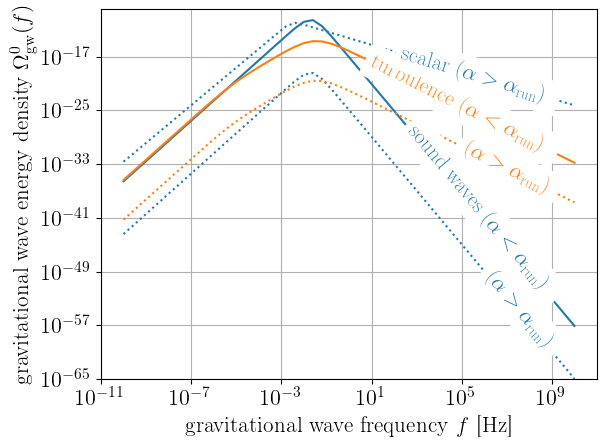

In [293]:
# sample GW spectra
f_table = np.logspace(-10,10,51)*u.Hz
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(f_table/u.Hz, [ Omega_gw(f, source='sw',   T=1*u.TeV, alpha_run=np.inf) for f in f_table ],
         c=default_colors[0], label=r'sound waves ($\alpha < \alpha_\text{run}$)')
plt.plot(f_table/u.Hz, [ Omega_gw(f, source='turb', T=1*u.TeV, alpha_run=np.inf) for f in f_table ],
         c=default_colors[1], label=r'turbulence ($\alpha < \alpha_\text{run}$)')

plt.plot(f_table/u.Hz, [ Omega_gw(f, source='phi',  T=1*u.TeV, alpha_run=0.00001) for f in f_table ],
         c=default_colors[0], ls=':', label=r'scalar ($\alpha > \alpha_\text{run}$)')
plt.plot(f_table/u.Hz, [ Omega_gw(f, source='sw',   T=1*u.TeV, alpha_run=0.00001) for f in f_table ],
         c=default_colors[0], ls=':', label=r'($\alpha > \alpha_\text{run}$)')
plt.plot(f_table/u.Hz, [ Omega_gw(f, source='turb', T=1*u.TeV, alpha_run=0.00001) for f in f_table ],
         c=default_colors[1], ls=':', label=r'($\alpha > \alpha_\text{run}$)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'gravitational wave frequency $f$ [Hz]')
plt.ylabel(r'gravitational wave energy density $\Omega_\text{gw}^0(f)$')
ll.labelLines(plt.gca().get_lines(), xvals=(1e9,1e9,1e9,1e9,1e9), ha='right', align=True, backgroundcolor='white')
plt.ylim(1e-65,1e-10)
plt.grid()
plt.show()

/var/folders/mn/vwbz05810sq7zq664_pw0ll40000gn/T/ipykernel_77241/4170096130.py:60: RuntimeWarning: divide by zero encountered in log10
  cp = ax1.contour(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table[n,alpha,coh]),
/var/folders/mn/vwbz05810sq7zq664_pw0ll40000gn/T/ipykernel_77241/4170096130.py:63: RuntimeWarning: divide by zero encountered in log10
  ax1.contourf(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table[n,alpha,coh]),


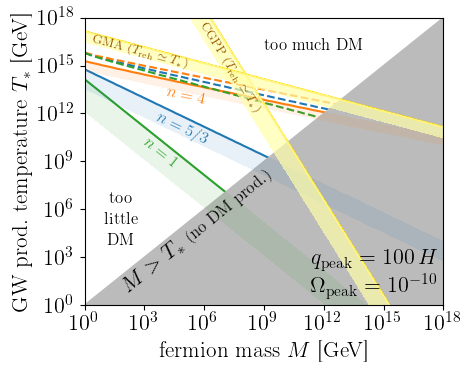

In [1812]:
# parameter space plots
# ---------------------

# calculate Omega tables for realistic PT spectra
# Omega_R_table = {}
# peak_table    = {}
# n_table       = {'turb': 5/3, 'sw': 4, 'phi': 1} # see https://arxiv.org/abs/2204.09661 and references therein
# M_table       = np.logspace(3, 18, 76) * u.GeV
# T_star_table  = np.logspace(3, 18, 76) * u.GeV
# for s in ['phi', 'sw', 'turb']:
#     peak_table[s,'norun'] = [ opt.minimize(lambda logf: -Omega_gw(10**logf, source=s, T=T, alpha_run=np.inf),
#                                            x0=np.log10(100*Hubble(T)), method='Powell')
#                                   for T in T_star_table ]
#     peak_table[s,'run'] = [ opt.minimize(lambda logf: -Omega_gw(10**logf, source=s, T=T, alpha_run=0.00001),
#                                            x0=np.log10(100*Hubble(T)), method='Powell')
#                                   for T in T_star_table ]
#     for r in ['run','norun']:
#         Omega_R_table[s,r] = np.array([[Omega_DM(M, T_star, n=n_table[s], q_peak=2*np.pi*10**p.x[0], Omega_peak=-p.fun)
#                                       for M in M_table] for p, T_star in zip(peak_table[s,r], T_star_table)]) / u.rho_c0

# calculate lower-level Omega tables for more generic GW sources
Omega_peak    = 1e-10
Omega_R_table = {}
M_table       = np.logspace(3, 18, 76) * u.GeV
T_star_table  = np.logspace(3, 18, 76) * u.GeV
M_table       = np.logspace(0, 18, 91) * u.GeV
T_star_table  = np.logspace(0, 18, 91) * u.GeV
alpha         = 100
alpha_table   = [alpha, alpha, alpha, alpha, alpha, alpha]
n_table       = [5/3,       4,     1,   5/3,     4,     1]
coh_table     = [False, False, False,  True,  True,  True]
for n, alpha, coh in zip(n_table, alpha_table, coh_table):
    Omega_R_table[n, alpha, coh] = np.array([[Omega_DM(M=M, T_star=T_star, n=n, Omega_peak=Omega_peak,
                                              q_peak=alpha * u.T0*g_star_S(u.T0)**(1/3)/(T_star*g_star_S(T_star)**(1/3)) * Hubble(T_star),
                                              beta_over_H=alpha, coherent=coh)
                              for M in M_table] for T_star in T_star_table])

# This custom formatter removes trailing zeros, e.g. "1.0" becomes "1", and
# then adds a percent sign.
def fmt_log(x):
    s = f"{np.log10(x):.1f}"
    if s.endswith("0"):
        s = f"{np.log10(x):.0f}"
    return s

# plot Omega
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
my_colors      = [ default_colors[0], default_colors[1], default_colors[2],
                   default_colors[0], default_colors[1], default_colors[2]]
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
ax1.set_xscale('log')
ax1.set_yscale('log')
#for s in ['phi']:
#    cp = ax1.contour(M_table/u.GeV, T_star_table/u.GeV, Omega_R_table[s,'run'], levels=[0,u.Omega_dm],
#                     colors=['k'])
#    ax1.contour(M_table/u.GeV, T_star_table/u.GeV, Omega_R_table[s,'run'], levels=[0,u.Omega_dm],
#                colors=['k'])
for j, n, alpha, coh in zip(range(len(n_table)), n_table, alpha_table, coh_table):
    cp = ax1.contour(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table[n,alpha,coh]),
                     levels=[np.log10(u.Omega_dm)], colors=[my_colors[j]], linestyles=['-' if coh==False else '--'])
    if coh == False:
        ax1.contourf(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table[n,alpha,coh]),
                     levels=[np.log10(0.01*u.Omega_dm),np.log10(u.Omega_dm)],
                     colors=[my_colors[j]], alpha=0.1, zorder=2.4)
#    cl = ax1.clabel(cp, inline=False, fontsize=14, fmt=lambda x: r'$q_\text{{peak}} = {:d} \, \mathcal{{H}}_*$'.format(alpha))
    if coh == True:
        loc   = [(0,0)]
        label = ''
    elif n == 4:
        loc   = [(5e4,5e11)]
        label = r'$n = {:s}$'.format(str(n))
    elif n == 5/3:
        loc   = [(5e2,1e6)]
        label = r'$n = {:s}$'.format(str(fractions.Fraction(n).limit_denominator()))
    else:
        loc   = [(5e2,3e8)]
        label = r'$n = {:s}$'.format(str(n))
    cl = ax1.clabel(cp, inline=False, fontsize=12, manual=loc, fmt=lambda x: label)
    cl[0].set_y(cl[0]._y/6)

# plot Omega from conventional heavy fermion production
Omega_R_table['cgpp'] = np.array([[Omega_CGPP(M, T_star) for M in M_table] for T_star in T_star_table])
cp2 = ax1.contour (M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table['cgpp']), levels=[np.log10(u.Omega_dm)],
             colors=['#ffdd00'], linestyles=['-'], zorder=2.4)
ax1.contourf(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table['cgpp']), levels=[np.log10(0.01*u.Omega_dm),np.log10(u.Omega_dm)],
             colors=['#ffffaa'], alpha=0.7, zorder=2.4)
#cl2 = ax1.clabel(cp2, inline=False, manual=[(2e5,3e15)], fontsize=12,
#                 fmt=lambda x: r'\parbox{10cm}{\centering cosmological prod.\\[0.5ex]\large ($T_\text{reh} \simeq T_*$)}')
cl2 = ax1.clabel(cp2, inline=False, manual=[(5e5,5e14)], fontsize=9,
                 fmt=lambda x: r'\parbox{10cm}{CGPP ($T_\text{reh} \simeq T_*$)}')
cl2[0].set_y(cl2[0]._y/10)
cl2[0].set_color('#995500')

# ... and from graviton-mediated inflaton annihilation
Omega_R_table['gma'] = np.array([[Omega_GMA(M, T_star) for M in M_table] for T_star in T_star_table])
cp3 = ax1.contour (M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table['gma']), levels=[np.log10(u.Omega_dm)],
             colors=['#ffdd00'], linestyles=['-'], zorder=2.4)
ax1.contourf(M_table/u.GeV, T_star_table/u.GeV, np.log10(Omega_R_table['gma']), levels=[np.log10(0.01*u.Omega_dm),np.log10(u.Omega_dm)],
             colors=['#ffffaa'], alpha=0.7, zorder=2.4)
#cl3 = ax1.clabel(cp3, inline=False, manual=[(7e8,1e14)], fontsize=12,
#                 fmt=lambda x: r'\parbox{10cm}{\centering graviton-mediated ann.\\[0.5ex]\large ($T_\text{reh} \simeq T_*$)}')
cl3 = ax1.clabel(cp3, inline=False, manual=[(2e2,1e14)], fontsize=9,
                 fmt=lambda x: r'\parbox{10cm}{\centering GMA ($T_\text{reh} \simeq T_*$)}')
cl3[0].set_y(cl3[0]._y/2)
cl3[0].set_color('#995500')

# annotation and fine-tuning of the plot
# cp4 = ax1.plot(M_table/u.GeV,   np.sqrt(M_table / 1.66 / np.sqrt(106.75) / np.sqrt(8*np.pi*u.GN)) / u.GeV, color='k', ls='--')
# ax1.fill_between(M_table/u.GeV, np.sqrt(M_table / 1.66 / np.sqrt(106.75) / np.sqrt(8*np.pi*u.GN)) / u.GeV, 1e-20, color='#00000011')
# #ll.labelLine(cp4[0], 1e11, label=r'$M > H_*$ (mass generated at $T \ll T_*$)', color='k', yoffset=-5e13, fontsize=14,
# #             va='top', backgroundcolor="none")
# ax1.annotate(r'$M > H_*$ {\Large (mass generated at $T \ll T_*$)}', (2e6,1e11), rotation=19.2,
#              bbox=dict(boxstyle='square', pad=0, fc='#eeeeeeaa', edgecolor='#eeeeeeaa', lw=None))

ax1.fill_between(M_table/u.GeV, M_table/u.GeV, 1e-20, color='#bbbbbb', zorder=2.3)
#ax1.annotate(r'\parbox{1.8cm}{\centering\Large too little DM', (1.8e3,8e6), ha='left', va='top',
#             bbox=dict(boxstyle='square', pad=0.2, fc='#eeeeee', edgecolor='#eeeeee', lw=None), zorder=2)
ax1.annotate(r'\parbox{1.5cm}{\centering too little DM', (2e0,2e5) if Omega_peak==1e-06 else (1e1,1e7), ha='left', va='top',  fontsize=12,
             bbox=dict(boxstyle='square', pad=0.02, fc='white', edgecolor='white', lw=None), zorder=2)
ax1.annotate(r'too much DM', (1e9,1e16), fontsize=12,
             bbox=dict(boxstyle='square', pad=0.02, fc='white', edgecolor='white', lw=None))
ax1.annotate(r'$q_\text{{peak}} = {:d}\,H$'.format(int(alpha)), (0.98,0.12), xycoords='axes fraction', ha='right', va='bottom')
ax1.annotate(r'$\Omega_\text{{peak}} = 10^{{{:d}}}$'.format(int(np.round(np.log10(Omega_peak)))), (0.98,0.02), xycoords='axes fraction', ha='right', va='bottom')

if Omega_peak == 1e-6 and alpha == 100:
    ax1.annotate(r'$M > T_*$ {\large (no DM prod.)}', (1.5e10,2e9), rotation=39)
    ax1.annotate(r'\parbox{9cm}{\flushright CGPP: cosmological \\[-0.1cm] grav. particle production}',
                 (0.98,0.4),  xycoords='axes fraction', ha='right', fontsize=13)
    ax1.annotate(r'GMA: graviton-mediated ann.',
                 (0.98,0.25), xycoords='axes fraction', ha='right', fontsize=13)
    legend1 = ax1.legend([ matplotlib.lines.Line2D(xdata=[0,1], ydata=[0,0], color='k', ls='-'),
                           matplotlib.lines.Line2D(xdata=[0,1], ydata=[0,0], color='k', ls='--') ],
                         [ 'incoh.', 'coh.' ], loc=(0.23,0.03), labelspacing=0.36,
                         handlelength=1.5, handletextpad=0.5, fontsize=16, borderpad=0,
                         edgecolor='white', facecolor='white', framealpha=0)
    ax1.add_artist(legend1)
else:
    ax1.annotate(r'$M > T_*$ {\large (no DM prod.)}', (5e1,0.7e1), rotation=39)

ax1.set_xlabel(r'fermion mass $M$ [GeV]')
ax1.set_ylabel(r'GW prod.\ temperature $T_*$ [GeV]')
ax1.set_xlim(min(M_table/u.GeV), max(M_table/u.GeV))
ax1.set_ylim(min(T_star_table/u.GeV), max(T_star_table/u.GeV))
ax1.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([1e0,1e3,1e6,1e9,1e12,1e15,1e18]))
#ax1.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(10**np.arange(3,18)))
ax1.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([1e0,1e3,1e6,1e9,1e12,1e15,1e18]))
#ax1.grid()

plt.tight_layout()
suffix = '-'+str(Omega_peak)+'-'+str(alpha)
plt.savefig('OmegaD-Plot'+suffix+'.pdf', bbox_inches='tight')
plt.show()